In [1]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
from src.codes.algorithms.ecsw import ecsw_red
from importlib import reload

### class for data (geometry, material property, mesh)

In [3]:
nref= [3,3,3]
L = [10.,12.,14.]

mat_layout = np.zeros((4,4,4),dtype=int)
src_layout = np.zeros((4,4,4),dtype=int)

# src_layout[0,0,0] = 1
# src_layout[1,1,1] = 1
# src_layout[2,2,2] = 1
# src_layout[3,3,3] = 1

In [4]:
fdict = {}

cond_list = []
cond_list.append( lambda T,mu: mu*T + 100. + 0.*T )
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append( lambda T,mu: mu + 0. + 0.*T )
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 0.0+100.0 + 0.*T )
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [5]:
bc = {}
bc['x_min']={'type':'dirichlet','value':0.}
bc['x_max']={'type':'dirichlet','value':0.}
bc['y_min']={'type':'dirichlet','value':0.}
bc['y_max']={'type':'dirichlet','value':0.}
bc['z_min']={'type':'dirichlet','value':0.}
bc['z_max']={'type':'dirichlet','value':0.}

### Simulate FOS

In [6]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []


 Snap 0


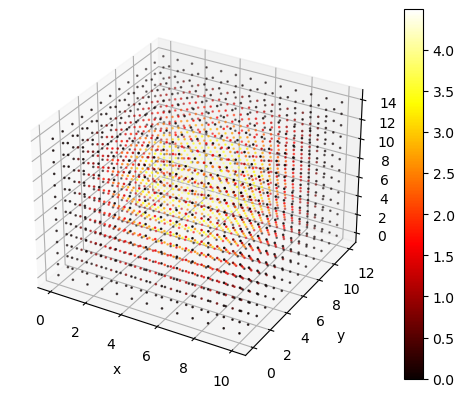


 Snap 1


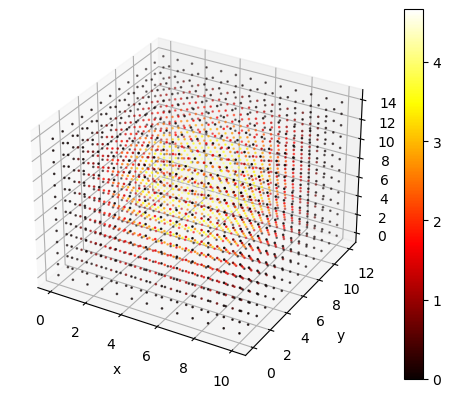


 Snap 2


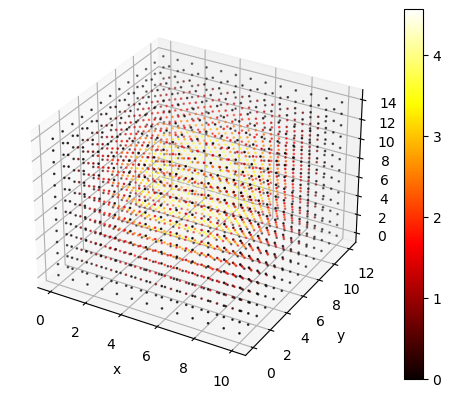


 Snap 3

 Snap 4

 Snap 5

 Snap 6

 Snap 7

 Snap 8

 Snap 9

 Snap 10

 Snap 11

 Snap 12

 Snap 13

 Snap 14


In [7]:
for i in range(N_snap):
    print(f"\n Snap {i}")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=3)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 4.0
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    if i<3:
        plot3D(d.xi[0], d.xi[1], d.xi[2], NL_solution_p, hmap=True)

In [8]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 2197)


### ECSW Hyper-reduction
#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

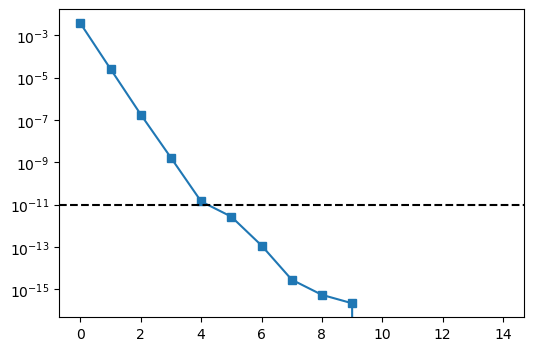

In [9]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=1e-11)
V_sel = U[:, :n_sel]

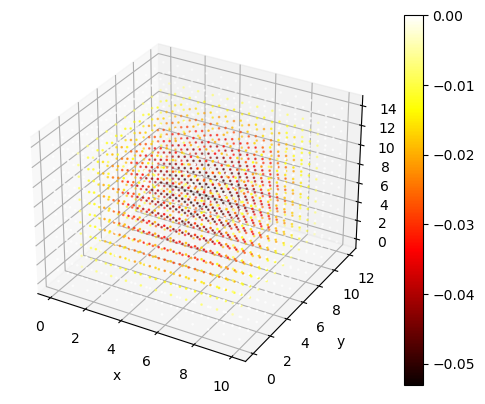

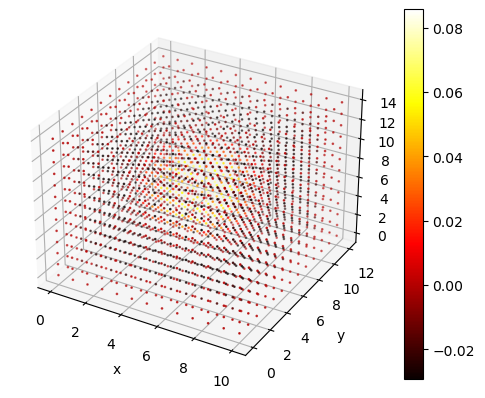

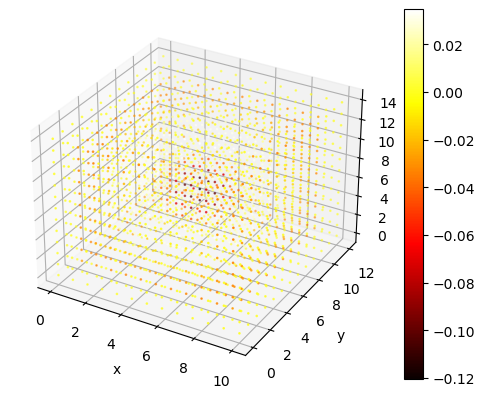

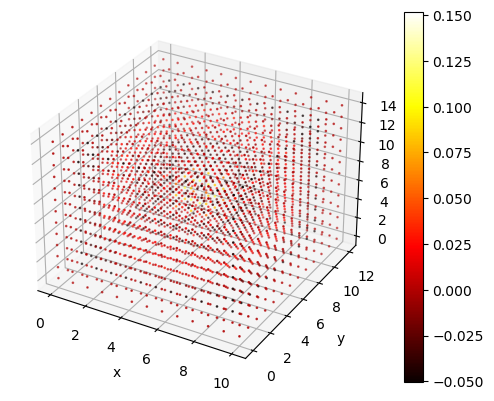

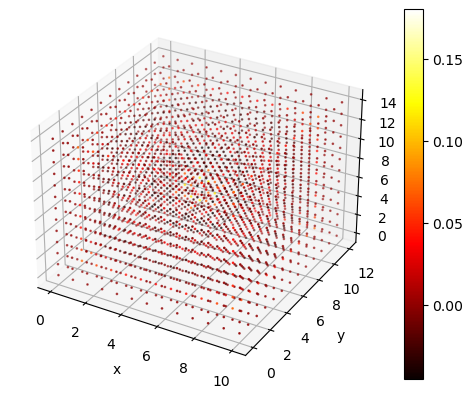

In [10]:
for i in range(n_sel):
    plot3D(d.xi[0],d.xi[1],d.xi[2],V_sel[:,i],hmap=True)

 
#### Step2: ECSW

In [30]:
tic_h_setup_b = time.time()
tol = 1e-10
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap, mask,NL_solutions,tol=tol)
toc_h_setup_b = time.time()

In [31]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 8.273107871364166e-06


In [32]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

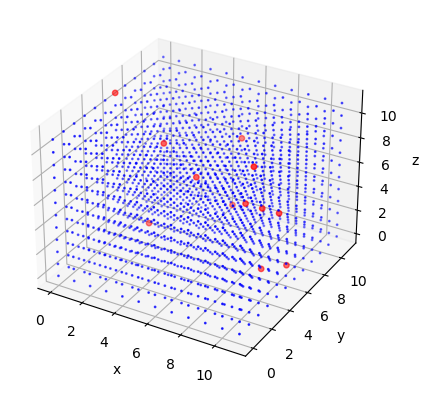

In [33]:
plot3D(np.arange(d.ncells[0]),np.arange(d.ncells[1]),np.arange(d.ncells[2]),xi, sz = sizes, clr = colors, save_file=False)

In [34]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 0.6944444444444444%


### ROM Simulation

In [35]:
# Choose unknown parameter

params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [36]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, nref, L, param_rom, pb_dim=3)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_ecsw(d_test, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [37]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 2.
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [38]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [39]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
toc_rom_woh = time.time()

In [40]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

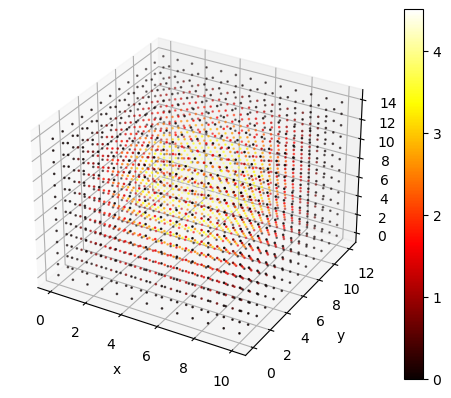

RMS_error is 0.0005300841893942678 %


In [41]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], sol_red,hmap=True)
print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

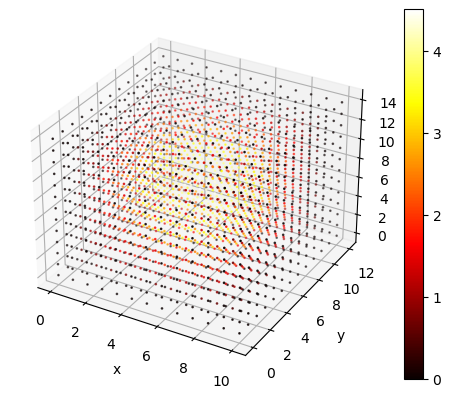



ROM Error without hyperreduction is 1.5224128392307633e-09 %


In [42]:
plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], NL_solution_p_fos_test,hmap=True)

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

 
### Speedups

In [43]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [44]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:1.2083611328066928
speedup with hyperreduction:175.60065235224417
